#  Fusion model
- a **visual branch** (EfficientNet via `timm` + temporal attention pooling)
- an **rPPG branch** (POS-based rPPG waveform features + FFT/SNR features)
- a **fusion head** (MLP)

Imbalance handling:
- `WeightedRandomSampler`
- **Focal Loss**
- threshold tuning (optimize for precision/recall tradeoff)


## Setup

In [ ]:
# Install deps
import sys
import os
import time

IN_COLAB = "google.colab" in sys.modules
print("IN_COLAB:", IN_COLAB)
print("python:", sys.version)

# Core ML + vision
%pip install -q --upgrade timm albumentations
%pip install -q facenet-pytorch --no-deps

# Utilities
%pip install -q kaggle gdown pyarrow scipy

print("Installs complete")

IN_COLAB: True
python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.0 MB/s eta 0:00:00
Installs complete


In [ ]:
import random
import math
from pathlib import Path
from collections import defaultdict

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from facenet_pytorch import MTCNN

from sklearn.metrics import (
    roc_auc_score, f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix, roc_curve,
    precision_recall_curve, average_precision_score
)

from scipy.signal import butter, filtfilt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("VRAM(GB):", round(torch.cuda.get_device_properties(0).total_memory / 1e9, 2))

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

set_seed(42)

# Paths (edit if needed)
DATA_ROOT = Path(os.environ.get("CELEBDF_ROOT", "/content/celeb-df-v2"))
METADATA_CSV = Path("metadata_celebdf_v2.csv")

# Cache dirs
CACHE_DIR = Path("cache")
CACHE_DIR.mkdir(exist_ok=True)
RPPG_CACHE_DIR = CACHE_DIR / "rppg_features"
RPPG_CACHE_DIR.mkdir(exist_ok=True, parents=True)
CHECKPOINT_DIR = Path("checkpoints_rppg_fusion")
CHECKPOINT_DIR.mkdir(exist_ok=True)


BACKBONE = "tf_efficientnet_b2_ns"
IMG_SIZE = 224
FRAMES_PER_VIDEO = 8

FPS_TARGET = 25

# rPPG cache extraction budget
RPPG_CLIP_LEN = 96           # frames decoded for rPPG feature extraction
RPPG_STRIDE = 3              # decode every 3rd frame => ~32 samples
RPPG_BPM_BAND = (42, 240)    # 0.7–4.0 Hz

BATCH_SIZE = 8
ACCUMULATION_STEPS = 1
LR = 2e-4
NUM_EPOCHS = 8
GRAD_CLIP = 1.0

TTA_PASSES = 10

print("DATA_ROOT:", DATA_ROOT)

Device: cuda
GPU: NVIDIA A100-SXM4-40GB
VRAM(GB): 42.47
DATA_ROOT: /content/celeb-df-v2


## Dataset (Celeb-DF v2) download / setup on Colab

After setup, `DATA_ROOT` must contain:
- `Celeb-real/`
- `YouTube-real/`
- `Celeb-synthesis/`
- `List_of_testing_videos.txt`


In [ ]:
KAGGLE_DATASET = os.environ.get("KAGGLE_DATASET", "reubensuju/celeb-df-v2")  # e.g. "yourname/celeb-df-v2"
KAGGLE_TARGET_DIR = Path("/content")

if IN_COLAB and KAGGLE_DATASET:
    from google.colab import files

    # Ensure kaggle.json exists
    kaggle_dir = Path.home() / ".kaggle"
    kaggle_dir.mkdir(exist_ok=True)

    kaggle_json_path = kaggle_dir / "kaggle.json"
    if not kaggle_json_path.exists():
        print("Upload kaggle.json now...")
        uploaded = files.upload()
        # Robustly find kaggle.json content, even if Colab renames it (e.g., 'kaggle (1).json')
        found_kaggle_json = False
        for filename, content in uploaded.items():
            if "kaggle.json" in filename: # Check if 'kaggle.json' is part of the filename
                kaggle_json_path.write_bytes(content)
                found_kaggle_json = True
                break
        if not found_kaggle_json:
            print("No kaggle.json content found in uploaded files; please ensure you uploaded it.")

    if kaggle_json_path.exists():
        os.chmod(kaggle_json_path, 0o600)
        out_dir = KAGGLE_TARGET_DIR / "celeb-df-v2"
        out_dir.mkdir(exist_ok=True)

        # Download & unzip (dataset must be accessible in your Kaggle account)
        print(f"Downloading Kaggle dataset: {KAGGLE_DATASET} to {out_dir}")
        !kaggle datasets download -d {KAGGLE_DATASET} -p {out_dir} --unzip
        DATA_ROOT = out_dir
        print("Set DATA_ROOT =", DATA_ROOT)
    else:
        print("kaggle.json not found; use Option B/C")

# Validate structure
expected = [
    DATA_ROOT / "Celeb-real",
    DATA_ROOT / "YouTube-real",
    DATA_ROOT / "Celeb-synthesis",
    DATA_ROOT / "List_of_testing_videos.txt",
]
missing = [str(p) for p in expected if not p.exists()]

print("DATA_ROOT:", DATA_ROOT)
if missing:
    print("\n[!] Missing expected files/dirs:")
    for m in missing:
        print(" -", m)
    raise FileNotFoundError("Celeb-DF v2 not found / not extracted correctly. Fix DATA_ROOT then re-run.")

print("Dataset OK")

Dataset URL: https://www.kaggle.com/datasets/reubensuju/celeb-df-v2
License(s): unknown
 99% 9.20G/9.29G [00:30<00:00, 608MB/s]
100% 9.29G/9.29G [00:30<00:00, 325MB/s]
Set DATA_ROOT = /content/celeb-df-v2
DATA_ROOT: /content/celeb-df-v2
Dataset OK


## Build metadata (official test split)

- scan `Celeb-real`, `YouTube-real`, `Celeb-synthesis`
- mark `split=test` if listed in `List_of_testing_videos.txt`

In [ ]:
test_list_path = DATA_ROOT / "List_of_testing_videos.txt"

test_paths = []
with open(test_list_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        rel_path = parts[1] if len(parts) >= 2 and parts[0] in {"0", "1"} else parts[-1]
        test_paths.append(rel_path)

test_set = set(test_paths)
print(f"Loaded {len(test_set)} test entries")

rows = []
label_map = {"Celeb-real": 0, "YouTube-real": 0, "Celeb-synthesis": 1}

for vd in ["Celeb-real", "YouTube-real", "Celeb-synthesis"]:
    folder = DATA_ROOT / vd
    if not folder.exists():
        print("[WARN] Missing:", folder)
        continue
    for vf in folder.rglob("*.mp4"):
        rel_path = vf.relative_to(DATA_ROOT).as_posix()
        label = label_map.get(vf.parent.name)
        if label is None:
            continue
        rows.append({
            "video_path": rel_path,
            "label": int(label),
            "split": "test" if rel_path in test_set else "train",
        })

metadata_df = pd.DataFrame(rows)
metadata_df.to_csv(METADATA_CSV, index=False)
print("Saved:", METADATA_CSV)
print("Total:", len(metadata_df))
print(metadata_df.groupby(["split", "label"]).size())

metadata_df.head()

Loaded 518 test entries
Saved: metadata_celebdf_v2.csv
Total: 6529
split  label
test   0         178
       1         340
train  0         712
       1        5299
dtype: int64


,video_path,label,split
0,Celeb-real/id33_0002.mp4,0,test
1,Celeb-real/id57_0004.mp4,0,train
2,Celeb-real/id10_0004.mp4,0,train
3,Celeb-real/id55_0008.mp4,0,train
4,Celeb-real/id29_0003.mp4,0,train


       Real(0)  Fake(1)
split                  
test       178      340
train      712     5299


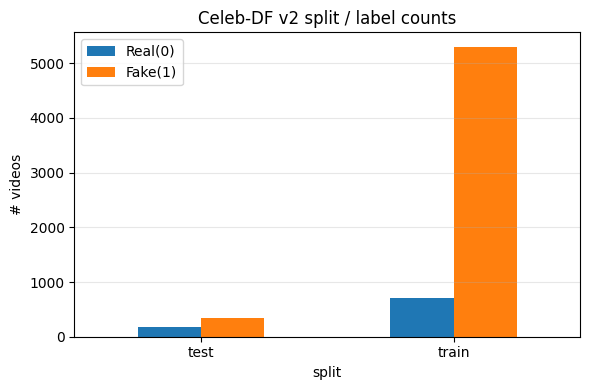

In [ ]:
import matplotlib.pyplot as plt

counts = metadata_df.groupby(["split", "label"]).size().unstack(fill_value=0)
counts.columns = ["Real(0)", "Fake(1)"]
print(counts)

ax = counts.plot(kind="bar", figsize=(6,4), rot=0)
ax.set_title("Celeb-DF v2 split / label counts")
ax.set_ylabel("# videos")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Fast video reading + face extraction (MTCNN)

Sample a small number of frames per video, extract aligned faces with MTCNN, and do video-level aggregation.

For rPPG, we detect a face bbox **once per video** (first valid frame) and reuse it for the clip to reduce compute.


In [ ]:
mtcnn = MTCNN(
    image_size=IMG_SIZE,
    margin=20,
    min_face_size=40,
    thresholds=[0.6, 0.7, 0.7],
    factor=0.709,
    post_process=True,
    device=DEVICE,
)
print("MTCNN ready")


def read_video_frames_fast(video_path: str, max_frames: int = 256, stride: int = 2):
    """Read up to max_frames frames using OpenCV, skipping by `stride` to reduce IO."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return []

    frames = []
    idx = 0
    grabbed = True
    while grabbed and len(frames) < max_frames:
        grabbed, frame = cap.read()
        if not grabbed:
            break
        if idx % stride == 0:
            frames.append(frame)
        idx += 1
    cap.release()
    return frames


def center_crop_square(frame_bgr, size=IMG_SIZE):
    h, w = frame_bgr.shape[:2]
    s = min(h, w)
    y0 = (h - s) // 2
    x0 = (w - s) // 2
    crop = frame_bgr[y0:y0+s, x0:x0+s]
    crop = cv2.resize(crop, (size, size), interpolation=cv2.INTER_AREA)
    return crop


def extract_face_aligned(frame_bgr, mtcnn_detector: MTCNN, target_size=IMG_SIZE):
    """Aligned face (RGB) via MTCNN. Falls back to center crop."""
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    try:
        face = mtcnn_detector(pil)  # torch tensor [3,H,W] or None
        if face is None:
            raise ValueError("No face")
        face = (face.permute(1, 2, 0).cpu().numpy() * 255.0).astype(np.uint8)
        return face
    except Exception:
        crop = center_crop_square(frame_bgr, size=target_size)
        return cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)


def detect_face_bbox_once(frame_bgr, mtcnn_detector: MTCNN):
    """Return bbox [x1,y1,x2,y2] in pixel coords for re-use. None if not found."""
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    try:
        boxes, _ = mtcnn_detector.detect(pil)
        if boxes is None or len(boxes) == 0:
            return None
        x1, y1, x2, y2 = boxes[0]
        return np.array([x1, y1, x2, y2], dtype=np.float32)
    except Exception:
        return None


def crop_bbox_rgb(frame_bgr, bbox, out_size=96, margin=0.2):
    """Crop bbox with margin, return RGB uint8."""
    h, w = frame_bgr.shape[:2]
    x1, y1, x2, y2 = bbox
    bw = x2 - x1
    bh = y2 - y1
    x1 = max(0, int(x1 - margin * bw))
    y1 = max(0, int(y1 - margin * bh))
    x2 = min(w, int(x2 + margin * bw))
    y2 = min(h, int(y2 + margin * bh))
    if x2 <= x1 or y2 <= y1:
        crop = center_crop_square(frame_bgr, size=out_size)
        return cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

    crop = frame_bgr[y1:y2, x1:x2]
    crop = cv2.resize(crop, (out_size, out_size), interpolation=cv2.INTER_AREA)
    return cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

MTCNN ready


## rPPG (POS) features + caching

We compute a compact rPPG feature vector per video using:
- POS projection (Wang et al.) on mean RGB of a fixed face ROI
- band-pass filtering (0.7–4.0 Hz)
- FFT-derived features (peak frequency/power ratios)

To keep runtime low, we cache features to disk (`cache/rppg_features/`).


In [ ]:
def _butter_bandpass(low_hz, high_hz, fs, order=3):
    nyq = 0.5 * fs
    low = low_hz / nyq
    high = high_hz / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a


def bandpass_filter(x, fs, low_hz=0.7, high_hz=4.0):
    if len(x) < 8:
        return x
    b, a = _butter_bandpass(low_hz, high_hz, fs, order=3)
    return filtfilt(b, a, x).astype(np.float32)


def pos_rppg_from_rgb_means(rgb_means: np.ndarray, fs: float):
    """POS rPPG from Nx3 array of mean RGB (float32). Returns 1D signal."""
    X = rgb_means.astype(np.float32)
    if X.ndim != 2 or X.shape[1] != 3 or X.shape[0] < 8:
        return np.zeros((max(1, X.shape[0]),), dtype=np.float32)

    # Normalize by temporal mean
    mean = X.mean(axis=0, keepdims=True) + 1e-6
    Xn = X / mean

    # POS projection
    # S1 = Xn[:,0] - Xn[:,1]
    # S2 = Xn[:,0] + Xn[:,1] - 2*Xn[:,2]
    S1 = Xn[:, 0] - Xn[:, 1]
    S2 = Xn[:, 0] + Xn[:, 1] - 2.0 * Xn[:, 2]

    # alpha to enforce equal std
    std_s1 = np.std(S1) + 1e-6
    std_s2 = np.std(S2) + 1e-6
    alpha = std_s1 / std_s2

    h = S1 - alpha * S2
    h = h - h.mean()

    # Bandpass physiological band
    h_f = bandpass_filter(h, fs=fs, low_hz=RPPG_BPM_BAND[0] / 60.0, high_hz=RPPG_BPM_BAND[1] / 60.0)
    h_f = (h_f - h_f.mean()) / (np.std(h_f) + 1e-6)
    return h_f.astype(np.float32)


def rppg_feature_vector(signal_1d: np.ndarray, fs: float):
    """Return compact feature vector from rPPG signal."""
    x = signal_1d.astype(np.float32)
    if len(x) < 16:
        return np.zeros((16,), dtype=np.float32)

    # Time-domain stats
    mean = float(np.mean(x))
    std = float(np.std(x))
    mad = float(np.mean(np.abs(x - np.mean(x))))
    zcr = float(np.mean((x[:-1] * x[1:]) < 0))  # zero-cross rate

    # FFT features
    n = len(x)
    freqs = np.fft.rfftfreq(n, d=1.0 / fs)
    spec = np.abs(np.fft.rfft(x)) ** 2

    # band mask in Hz
    low_hz = RPPG_BPM_BAND[0] / 60.0
    high_hz = RPPG_BPM_BAND[1] / 60.0
    mask = (freqs >= low_hz) & (freqs <= high_hz)

    spec_band = spec[mask]
    freqs_band = freqs[mask]
    if len(spec_band) < 2:
        peak_hz = 0.0
        peak_power = 0.0
        band_power = float(spec.sum())
    else:
        peak_idx = int(np.argmax(spec_band))
        peak_hz = float(freqs_band[peak_idx])
        peak_power = float(spec_band[peak_idx])
        band_power = float(np.sum(spec_band))

    total_power = float(np.sum(spec) + 1e-9)
    band_ratio = band_power / total_power
    peak_ratio = peak_power / (band_power + 1e-9)

    # simple SNR proxy: peak vs median of band
    med = float(np.median(spec_band) + 1e-9) if len(spec_band) else 1e-9
    snr = peak_power / med

    # BPM estimate
    bpm = peak_hz * 60.0

    feats = np.array([
        mean, std, mad, zcr,
        bpm, peak_hz, peak_ratio, band_ratio,
        snr,
        float(np.percentile(x, 5)), float(np.percentile(x, 95)),
        float(np.max(x)), float(np.min(x)),
        float(np.mean(np.diff(x))), float(np.std(np.diff(x))),
        float(n)
    ], dtype=np.float32)
    return feats


def _safe_cache_key(rel_video_path: str):
    return rel_video_path.replace("/", "__").replace("\\", "__")


def rppg_cache_path(rel_video_path: str):
    return RPPG_CACHE_DIR / f"{_safe_cache_key(rel_video_path)}.npz"


def compute_rppg_features_for_video(rel_video_path: str):
    full_path = DATA_ROOT / rel_video_path
    frames = read_video_frames_fast(str(full_path), max_frames=RPPG_CLIP_LEN, stride=RPPG_STRIDE)
    if len(frames) < 8:
        return np.zeros((16,), dtype=np.float32)

    # Approximate sampling rate after stride (unknown original FPS): assume 25fps baseline
    fs = FPS_TARGET / max(1, RPPG_STRIDE)

    # Detect bbox once (first frame)
    bbox = detect_face_bbox_once(frames[0], mtcnn)

    rgb_means = []
    for fr in frames:
        if bbox is None:
            roi_rgb = cv2.cvtColor(center_crop_square(fr, size=96), cv2.COLOR_BGR2RGB)
        else:
            roi_rgb = crop_bbox_rgb(fr, bbox, out_size=96, margin=0.2)
        rgb_means.append(roi_rgb.reshape(-1, 3).mean(axis=0))

    rgb_means = np.stack(rgb_means, axis=0).astype(np.float32)
    sig = pos_rppg_from_rgb_means(rgb_means, fs=fs)
    feats = rppg_feature_vector(sig, fs=fs)
    return feats


def get_rppg_features(rel_video_path: str, recompute: bool = False):
    cp = rppg_cache_path(rel_video_path)
    if cp.exists() and not recompute:
        try:
            d = np.load(cp)
            return d["feat"].astype(np.float32)
        except Exception:
            pass

    feat = compute_rppg_features_for_video(rel_video_path)
    try:
        np.savez_compressed(cp, feat=feat)
    except Exception:
        pass
    return feat

In [ ]:
# Quick sanity check on rPPG feature extraction (runs on 1 video)
sample_rel = metadata_df.iloc[0]["video_path"]
print("sample video:", sample_rel)
feat = get_rppg_features(sample_rel)
print("rPPG feat shape:", feat.shape)
print(feat)

sample video: Celeb-real/id33_0002.mp4
rPPG feat shape: (16,)
[ 0.0000000e+00  9.9985433e-01  7.5078744e-01  4.1052631e-01
  7.8125000e+01  1.3020834e+00  1.3822725e-01  9.7715020e-01
  9.3591290e+00 -1.5660186e+00  1.7723271e+00  3.2783494e+00
 -2.0055401e+00 -7.2464597e-04  1.2312474e+00  9.6000000e+01]


## Dataset + augmentations (video-level)

Each sample yields:
- `frames`: `T x 3 x H x W` (aligned faces)
- `rppg_feat`: cached rPPG feature vector
- `label`: 0/1

We use **WeightedRandomSampler** + **Focal Loss** to handle heavy class imbalance.


In [ ]:
from sklearn.model_selection import train_test_split

# Split train into train/val
base_train_df = metadata_df[metadata_df["split"] != "test"].reset_index(drop=True)
test_df = metadata_df[metadata_df["split"] == "test"].reset_index(drop=True)

val_ratio = 0.2
train_idx, val_idx = train_test_split(
    np.arange(len(base_train_df)),
    test_size=val_ratio,
    random_state=42,
    stratify=base_train_df["label"].values,
)
train_df = base_train_df.iloc[train_idx].reset_index(drop=True)
val_df = base_train_df.iloc[val_idx].reset_index(drop=True)

print("Train videos:", len(train_df), " Val videos:", len(val_df), " Test videos:", len(test_df))
print("Train label counts:\n", train_df["label"].value_counts())
print("Val label counts:\n", val_df["label"].value_counts())
print("Test label counts:\n", test_df["label"].value_counts())

# Albumentations transforms
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.HueSaturationValue(p=0.3),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    A.ImageCompression(quality_lower=40, quality_upper=100, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


def sample_frame_indices(num_frames_total: int, num_frames: int, rng: np.random.RandomState):
    if num_frames_total <= 0:
        return []
    if num_frames_total <= num_frames:
        return list(range(num_frames_total))
    # Uniform sampling with jitter
    ticks = np.linspace(0, num_frames_total - 1, num_frames)
    jitter = rng.uniform(-0.5, 0.5, size=num_frames)
    idx = np.clip(np.round(ticks + jitter), 0, num_frames_total - 1).astype(int)
    return idx.tolist()


class DeepfakeFusionDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform, num_frames=FRAMES_PER_VIDEO, seed=42):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.num_frames = int(num_frames)
        self.seed = int(seed)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        rel_path = row["video_path"]
        label = float(row["label"])

        full_path = DATA_ROOT / rel_path
        cap = cv2.VideoCapture(str(full_path))
        if not cap.isOpened():
            # Fallback
            frames_t = torch.zeros((self.num_frames, 3, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
            rppg_feat = torch.from_numpy(get_rppg_features(rel_path)).float()
            return frames_t, rppg_feat, torch.tensor(label, dtype=torch.float32)

        num_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        rng = np.random.RandomState(self.seed + idx)
        sel_idx = sample_frame_indices(num_total, self.num_frames, rng)

        frames = []
        for fi in sel_idx:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(fi))
            ok, frame_bgr = cap.read()
            if not ok:
                continue
            face_rgb = extract_face_aligned(frame_bgr, mtcnn, target_size=IMG_SIZE)
            if self.transform is not None:
                out = self.transform(image=face_rgb)
                frames.append(out["image"])  # [3,H,W]
            else:
                img = torch.from_numpy(face_rgb).permute(2, 0, 1).float() / 255.0
                frames.append(img)

        cap.release()

        if len(frames) == 0:
            frames_t = torch.zeros((self.num_frames, 3, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
        else:
            # Pad/repeat to fixed length
            while len(frames) < self.num_frames:
                frames.append(frames[len(frames) % len(frames)])
            frames_t = torch.stack(frames[: self.num_frames], dim=0)

        # rPPG cached features (computed once per video)
        rppg_feat = torch.from_numpy(get_rppg_features(rel_path)).float()

        return frames_t, rppg_feat, torch.tensor(label, dtype=torch.float32)


train_dataset = DeepfakeFusionDataset(train_df, transform=train_transform, num_frames=FRAMES_PER_VIDEO, seed=42)
val_dataset = DeepfakeFusionDataset(val_df, transform=val_transform, num_frames=FRAMES_PER_VIDEO, seed=1337)
test_dataset = DeepfakeFusionDataset(test_df, transform=val_transform, num_frames=FRAMES_PER_VIDEO, seed=2026)

# Weighted sampler (class-balanced)
train_labels = train_df["label"].values.astype(int)
class_counts = np.bincount(train_labels)
weight_per_class = 1.0 / np.maximum(class_counts, 1)
sample_weights = weight_per_class[train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Loaders ready")

Train videos: 4808  Val videos: 1203  Test videos: 518
Train label counts:
 label
1    4238
0     570
Name: count, dtype: int64
Val label counts:
 label
1    1061
0     142
Name: count, dtype: int64
Test label counts:
 label
1    340
0    178
Name: count, dtype: int64
Loaders ready


/tmp/ipython-input-1851238845.py:29: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
/tmp/ipython-input-1851238845.py:30: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=40, quality_upper=100, p=0.5),


## Fusion model (visual + rPPG)

Visual branch: EfficientNet features per frame + temporal attention pooling.

rPPG branch: MLP over cached rPPG(+FFT) features.

Fusion head: concatenation + MLP classifier.


In [ ]:
# Set MAX_CACHE=0 to skip.
MAX_CACHE = 0

if MAX_CACHE and MAX_CACHE > 0:
    paths = train_df["video_path"].tolist()[:MAX_CACHE]
    t0 = time.time()
    for p in tqdm(paths, desc=f"rPPG cache (first {MAX_CACHE})"):
        _ = get_rppg_features(p)
    print("rPPG cache done in", round(time.time() - t0, 1), "sec")


USE_MTCNN_BBOX = True  # if False, uses center crop (faster but usually worse)


class FastDeepfakeFusionDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform, num_frames=FRAMES_PER_VIDEO, seed=42):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.num_frames = int(num_frames)
        self.seed = int(seed)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        rel_path = row["video_path"]
        label = float(row["label"])

        full_path = DATA_ROOT / rel_path
        cap = cv2.VideoCapture(str(full_path))
        if not cap.isOpened():
            frames_t = torch.zeros((self.num_frames, 3, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
            rppg_feat = torch.from_numpy(get_rppg_features(rel_path)).float()
            return frames_t, rppg_feat, torch.tensor(label, dtype=torch.float32)

        num_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        rng = np.random.RandomState(self.seed + idx)
        sel_idx = sample_frame_indices(num_total, self.num_frames, rng)

        raw_frames = []
        for fi in sel_idx:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(fi))
            ok, frame_bgr = cap.read()
            if ok:
                raw_frames.append(frame_bgr)
        cap.release()

        if len(raw_frames) == 0:
            frames_t = torch.zeros((self.num_frames, 3, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
            rppg_feat = torch.from_numpy(get_rppg_features(rel_path)).float()
            return frames_t, rppg_feat, torch.tensor(label, dtype=torch.float32)

        # Detect bbox once
        bbox = None
        if USE_MTCNN_BBOX:
            bbox = detect_face_bbox_once(raw_frames[0], mtcnn)

        frames = []
        for fr in raw_frames:
            if bbox is None:
                face_rgb = cv2.cvtColor(center_crop_square(fr, size=IMG_SIZE), cv2.COLOR_BGR2RGB)
            else:
                face_rgb = crop_bbox_rgb(fr, bbox, out_size=IMG_SIZE, margin=0.2)

            if self.transform is not None:
                out = self.transform(image=face_rgb)
                frames.append(out["image"])
            else:
                img = torch.from_numpy(face_rgb).permute(2, 0, 1).float() / 255.0
                frames.append(img)

        while len(frames) < self.num_frames:
            frames.append(frames[len(frames) % len(frames)])

        frames_t = torch.stack(frames[: self.num_frames], dim=0)
        rppg_feat = torch.from_numpy(get_rppg_features(rel_path)).float()
        return frames_t, rppg_feat, torch.tensor(label, dtype=torch.float32)


train_dataset = FastDeepfakeFusionDataset(train_df, transform=train_transform, num_frames=FRAMES_PER_VIDEO, seed=42)
val_dataset = FastDeepfakeFusionDataset(val_df, transform=val_transform, num_frames=FRAMES_PER_VIDEO, seed=1337)

train_labels = train_df["label"].values.astype(int)
class_counts = np.bincount(train_labels)
weight_per_class = 1.0 / np.maximum(class_counts, 1)
sample_weights = weight_per_class[train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Fast loaders ready")

Fast loaders ready


In [ ]:
class TemporalAttentionPool(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(dim, dim // 4),
            nn.Tanh(),
            nn.Linear(dim // 4, 1),
        )

    def forward(self, x):
        # x: [B, T, D]
        w = self.attn(x)  # [B,T,1]
        w = torch.softmax(w, dim=1)
        return (x * w).sum(dim=1)


class FusionDetector(nn.Module):
    def __init__(self, backbone_name=BACKBONE, rppg_dim=16, dropout=0.4):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool="avg")
        feat_dim = self.backbone.num_features

        self.temporal_pool = TemporalAttentionPool(feat_dim)

        self.rppg_mlp = nn.Sequential(
            nn.Linear(rppg_dim, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
        )

        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(feat_dim + 128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 1),
        )

    def forward(self, frames, rppg_feat):
        # frames: [B,T,3,H,W]
        B, T, C, H, W = frames.shape
        x = frames.view(B * T, C, H, W)
        f = self.backbone(x)  # [B*T, D]
        f = f.view(B, T, -1)
        v = self.temporal_pool(f)  # [B, D]

        r = self.rppg_mlp(rppg_feat)  # [B, 128]
        z = torch.cat([v, r], dim=1)
        logits = self.head(z).squeeze(1)
        return logits


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = float(alpha)
        self.gamma = float(gamma)

    def forward(self, logits, targets):
        targets = targets.float()
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        pt = torch.exp(-bce)
        focal = (1 - pt) ** self.gamma
        alpha_w = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        loss = alpha_w * focal * bce
        return loss.mean()


model = FusionDetector(backbone_name=BACKBONE, rppg_dim=16, dropout=0.4).to(DEVICE)
criterion = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

use_amp = torch.cuda.is_available()
scaler = torch.amp.GradScaler('cuda') if use_amp else None

print("Model ready")

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b2_ns to current tf_efficientnet_b2.ns_jft_in1k.
  model = create_fn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

Model ready


In [ ]:
def _batch_to_device(batch):
    frames, rppg_feat, labels = batch
    frames = frames.to(DEVICE, non_blocking=True)
    rppg_feat = rppg_feat.to(DEVICE, non_blocking=True)
    labels = labels.to(DEVICE, non_blocking=True)
    return frames, rppg_feat, labels


@torch.no_grad()
def evaluate_loader(model, loader):
    model.eval()
    all_labels = []
    all_probs = []
    losses = []

    for batch in tqdm(loader, desc="Val", leave=False):
        frames, rppg_feat, labels = _batch_to_device(batch)
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
            logits = model(frames, rppg_feat)
            loss = criterion(logits, labels)
        probs = torch.sigmoid(logits).detach().cpu().numpy()

        losses.append(float(loss.detach().cpu()))
        all_labels.append(labels.detach().cpu().numpy())
        all_probs.append(probs)

    y = np.concatenate(all_labels)
    p = np.concatenate(all_probs)
    preds = (p >= 0.5).astype(int)

    val_loss = float(np.mean(losses)) if losses else 0.0
    val_acc = float((preds == y).mean()) if len(y) else 0.0
    val_auc = roc_auc_score(y, p) if len(np.unique(y)) > 1 else 0.5

    return val_loss, val_acc, val_auc, y, p


def train_model(model):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_auc": []}
    best_auc = -1.0
    best_path = CHECKPOINT_DIR / "best.pth"

    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        optimizer.zero_grad(set_to_none=True)

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}")
        for step, batch in enumerate(pbar, start=1):
            frames, rppg_feat, labels = _batch_to_device(batch)

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
                logits = model(frames, rppg_feat)
                loss = criterion(logits, labels) / ACCUMULATION_STEPS

            if use_amp:
                scaler.scale(loss).backward()
            else:
                loss.backward()

            if step % ACCUMULATION_STEPS == 0:
                if use_amp:
                    scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

                if use_amp:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad(set_to_none=True)

            running_loss += float(loss.detach().cpu()) * ACCUMULATION_STEPS
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            correct += int((preds == labels).sum().detach().cpu())
            total += int(labels.numel())

            pbar.set_postfix(loss=running_loss / max(1, step), acc=correct / max(1, total))

        scheduler.step()

        train_loss = running_loss / max(1, len(train_loader))
        train_acc = correct / max(1, total)

        val_loss, val_acc, val_auc, y_val, p_val = evaluate_loader(model, val_loader)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_auc"].append(val_auc)

        print(f"\nTrain Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")

        if val_auc > best_auc:
            best_auc = val_auc
            ckpt = {
                "epoch": epoch,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "best_auc": best_auc,
            }
            torch.save(ckpt, best_path)
            print(f"  [*] New best model! AUC: {best_auc:.4f}")

    print(f"\nTraining complete! Best Val AUC: {best_auc:.4f}")
    return history, best_path


history, best_ckpt_path = train_model(model)

Epoch 1/8: 100%|██████████| 601/601 [11:13<00:00,  1.12s/it, acc=0.722, loss=0.0577]



Train Loss: 0.0577, Acc: 0.7221
Val   Loss: 0.0506, Acc: 0.7556, AUC: 0.9347
  [*] New best model! AUC: 0.9347


Epoch 2/8: 100%|██████████| 601/601 [07:21<00:00,  1.36it/s, acc=0.876, loss=0.0292]



Train Loss: 0.0292, Acc: 0.8756
Val   Loss: 0.0182, Acc: 0.9019, AUC: 0.9743
  [*] New best model! AUC: 0.9743


Epoch 3/8: 100%|██████████| 601/601 [06:05<00:00,  1.64it/s, acc=0.927, loss=0.0199]



Train Loss: 0.0199, Acc: 0.9270
Val   Loss: 0.0136, Acc: 0.9335, AUC: 0.9856
  [*] New best model! AUC: 0.9856


Epoch 4/8: 100%|██████████| 601/601 [05:17<00:00,  1.89it/s, acc=0.955, loss=0.0132]



Train Loss: 0.0132, Acc: 0.9551
Val   Loss: 0.0109, Acc: 0.9559, AUC: 0.9899
  [*] New best model! AUC: 0.9899


Epoch 5/8: 100%|██████████| 601/601 [04:57<00:00,  2.02it/s, acc=0.971, loss=0.00988]



Train Loss: 0.0099, Acc: 0.9711
Val   Loss: 0.0122, Acc: 0.9418, AUC: 0.9908
  [*] New best model! AUC: 0.9908


Epoch 6/8: 100%|██████████| 601/601 [04:40<00:00,  2.14it/s, acc=0.985, loss=0.00397]



Train Loss: 0.0040, Acc: 0.9852
Val   Loss: 0.0100, Acc: 0.9659, AUC: 0.9944
  [*] New best model! AUC: 0.9944


Epoch 7/8: 100%|██████████| 601/601 [04:33<00:00,  2.20it/s, acc=0.992, loss=0.00202]



Train Loss: 0.0020, Acc: 0.9919
Val   Loss: 0.0131, Acc: 0.9742, AUC: 0.9946
  [*] New best model! AUC: 0.9946


Epoch 8/8: 100%|██████████| 601/601 [04:27<00:00,  2.25it/s, acc=0.993, loss=0.00264]



Train Loss: 0.0026, Acc: 0.9929
Val   Loss: 0.0112, Acc: 0.9792, AUC: 0.9958
  [*] New best model! AUC: 0.9958

Training complete! Best Val AUC: 0.9958


Loaded best checkpoint (epoch 8, val_auc=0.9958)
Evaluating VAL: 1203 videos with TTA (x5)...


Eval: 100%|██████████| 1203/1203 [06:28<00:00,  3.09it/s]



Chosen threshold (VAL max Balanced Acc): 0.4039
Evaluating TEST: 518 videos with TTA (x10)...


Eval: 100%|██████████| 518/518 [04:18<00:00,  2.00it/s]



=== TEST Results (TTA x10) @ threshold=0.4039 (VAL-tuned for Balanced Acc) ===
Accuracy:     0.9054
Balanced Acc: 0.9105
F1 Score:     0.9254
AUC:          0.9708

Classification Report:
              precision    recall  f1-score   support

        Real     0.8209    0.9270    0.8707       178
        Fake     0.9590    0.8941    0.9254       340

    accuracy                         0.9054       518
   macro avg     0.8899    0.9105    0.8981       518
weighted avg     0.9115    0.9054    0.9066       518



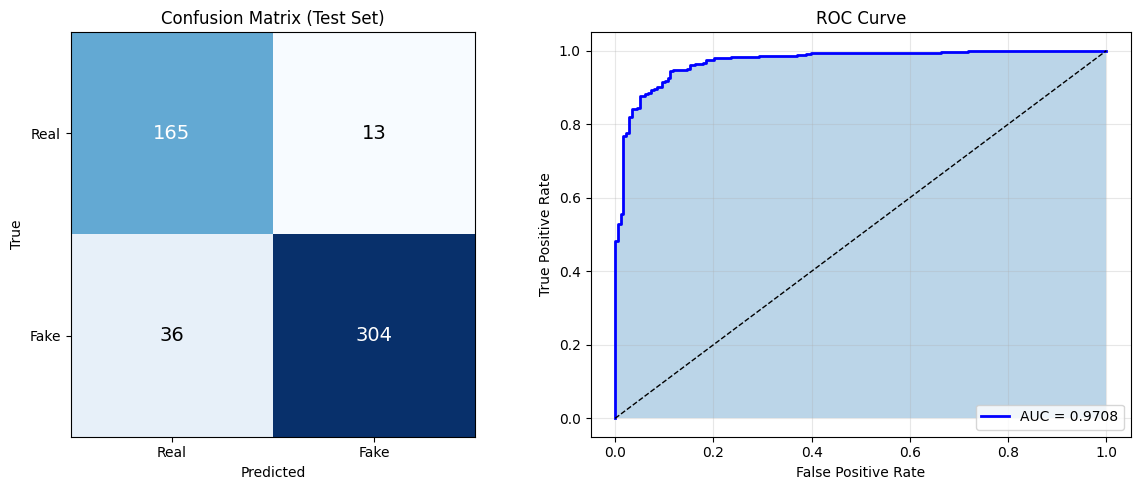


Final Test AUC: 0.9708
Test AP (PR-AUC): 0.9841


In [ ]:
# Load best checkpoint
ckpt = torch.load(CHECKPOINT_DIR / "best.pth", map_location=DEVICE, weights_only=False)
model.load_state_dict(ckpt["model"])
model.eval()
print(f"Loaded best checkpoint (epoch {ckpt['epoch']}, val_auc={ckpt['best_auc']:.4f})")


def _make_frames_tensor_from_list(frames_bgr, bbox, flip=False):
    imgs = []
    for fr in frames_bgr:
        if bbox is None:
            face_rgb = cv2.cvtColor(center_crop_square(fr, size=IMG_SIZE), cv2.COLOR_BGR2RGB)
        else:
            face_rgb = crop_bbox_rgb(fr, bbox, out_size=IMG_SIZE, margin=0.2)
        if flip:
            face_rgb = np.ascontiguousarray(face_rgb[:, ::-1, :])
        out = val_transform(image=face_rgb)
        imgs.append(out["image"])
    while len(imgs) < FRAMES_PER_VIDEO:
        imgs.append(imgs[len(imgs) % len(imgs)])
    x = torch.stack(imgs[:FRAMES_PER_VIDEO], dim=0)
    return x


@torch.no_grad()
def evaluate_with_tta_fusion(model, df: pd.DataFrame, num_tta=TTA_PASSES, split_name="SET"):
    """Return (labels, probs) at video-level using TTA."""
    all_labels = []
    all_probs = []

    print(f"Evaluating {split_name}: {len(df)} videos with TTA (x{num_tta})...")

    for rel_path, label in tqdm(zip(df["video_path"].tolist(), df["label"].tolist()), total=len(df), desc="Eval"):
        full_path = DATA_ROOT / rel_path
        frames = read_video_frames_fast(str(full_path), max_frames=max(64, FRAMES_PER_VIDEO * num_tta * 4), stride=2)
        if len(frames) < 4:
            continue

        bbox = detect_face_bbox_once(frames[0], mtcnn) if USE_MTCNN_BBOX else None
        rppg_feat = torch.from_numpy(get_rppg_features(rel_path)).float().to(DEVICE).unsqueeze(0)

        video_probs = []
        for t in range(num_tta):
            rng = np.random.RandomState(1234 + t)
            idx = rng.choice(len(frames), size=min(FRAMES_PER_VIDEO, len(frames)), replace=len(frames) < FRAMES_PER_VIDEO)
            sel = [frames[i] for i in idx]
            x = _make_frames_tensor_from_list(sel, bbox=bbox, flip=(t % 2 == 1)).to(DEVICE).unsqueeze(0)

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
                logit = model(x, rppg_feat)
                prob = torch.sigmoid(logit).item()
            video_probs.append(prob)

        all_labels.append(int(label))
        all_probs.append(float(np.mean(video_probs)))

    y = np.array(all_labels, dtype=np.int32)
    p = np.array(all_probs, dtype=np.float32)
    return y, p


# Balanced threshold selection
TTA_VAL = max(3, TTA_PASSES // 2)

val_labels, val_probs = evaluate_with_tta_fusion(model, val_df, num_tta=TTA_VAL, split_name="VAL")

# Choose threshold that maximizes Balanced Accuracy on VAL.
fpr_v, tpr_v, thr_v = roc_curve(val_labels, val_probs)
bal_v = 0.5 * (tpr_v + (1.0 - fpr_v))
finite = np.isfinite(thr_v)
if np.any(finite):
    best_i = int(np.argmax(bal_v[finite]))
    best_thr = float(thr_v[finite][best_i])
else:
    best_thr = 0.5

print(f"\nChosen threshold (VAL max Balanced Acc): {best_thr:.4f}")

# Evaluate TEST probabilities with TTA
test_labels, test_probs = evaluate_with_tta_fusion(model, test_df, num_tta=TTA_PASSES, split_name="TEST")

# Report metrics at tuned threshold
preds = (np.array(test_probs) >= best_thr).astype(int)
acc = float((preds == test_labels).mean())
bal_acc = float(balanced_accuracy_score(test_labels, preds))
f1 = float(f1_score(test_labels, preds))
auc_score = float(roc_auc_score(test_labels, test_probs)) if len(np.unique(test_labels)) > 1 else 0.5

print(f"\n=== TEST Results (TTA x{TTA_PASSES}) @ threshold={best_thr:.4f} (VAL-tuned for Balanced Acc) ===")
print(f"Accuracy:     {acc:.4f}")
print(f"Balanced Acc: {bal_acc:.4f}")
print(f"F1 Score:     {f1:.4f}")
print(f"AUC:          {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, preds, digits=4, target_names=["Real", "Fake"]))

# Confusion matrix + ROC
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm = confusion_matrix(test_labels, preds)
im = axes[0].imshow(cm, cmap='Blues')
axes[0].set_title('Confusion Matrix (Test Set)')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Real', 'Fake'])
axes[0].set_yticklabels(['Real', 'Fake'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, cm[i, j], ha='center', va='center',
                     color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=14)

fpr, tpr, _ = roc_curve(test_labels, test_probs)
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_score:.4f}')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].fill_between(fpr, tpr, alpha=0.3)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Test AUC: {auc_score:.4f}")

# PR-AUC
ap = average_precision_score(test_labels, test_probs)
print(f"Test AP (PR-AUC): {ap:.4f}")

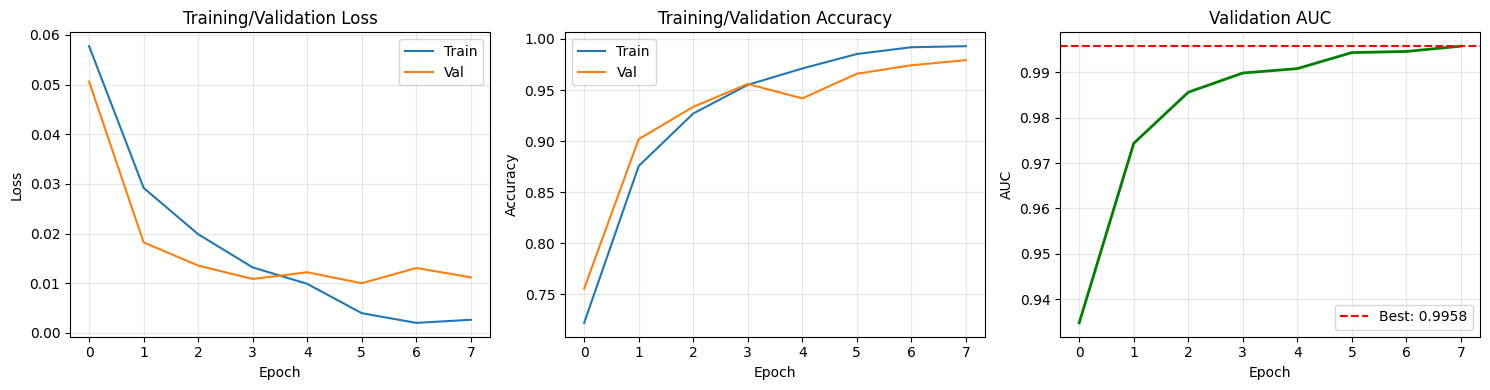

In [ ]:
# Training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history.get('train_loss', []), label='Train')
axes[0].plot(history.get('val_loss', []), label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training/Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.get('train_acc', []), label='Train')
axes[1].plot(history.get('val_acc', []), label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training/Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# AUC
val_auc_hist = history.get('val_auc', [])
axes[2].plot(val_auc_hist, 'g-', linewidth=2)
if len(val_auc_hist):
    axes[2].axhline(y=max(val_auc_hist), color='r', linestyle='--', label=f"Best: {max(val_auc_hist):.4f}")
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Validation AUC')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()